### Loading our data

For the following exercise we will use the word count matrix representation and only use a small subset of our data since we will implement a naiveBayes classifier - which is a "lazy learner" and so predictions will be rather slow.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools

classes_en = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
train_en = pd.read_csv("https://raw.githubusercontent.com/michabirklbauer/hgb_dse_text_mining/master/data/AGNews/train.csv", 
                       names = ["Label", "Title", "Article"],
                       encoding = "utf-8")
test_en = pd.read_csv("https://raw.githubusercontent.com/michabirklbauer/hgb_dse_text_mining/master/data/AGNews/test.csv", 
                      names = ["Label", "Title", "Article"],
                      encoding = "utf-8")

sample = train_en.sample(100)

### Splitting data into a training dataset and a test dataset

*Note:* Data splitting should be your first step in any data science project that involves some kind of machine learning, doing transformations - even something like word counts - will inherently introduce bias and make the calculated generalization error on the test datast less meaningful!

In [2]:
train, test = train_test_split(sample, test_size = 0.35, random_state = 1337)
print(train.shape)
print(test.shape)
train.head()

(65, 3)
(35, 3)


,Label,Title,Article
40696,4,Virgin seeks slice of net music,Virgin becomes one of the first major music re...
75663,3,Delta pilots agreed on cost saving package,"On Wednesday, Delta pilots agreed on cost savi..."
1461,4,Rival Targets Apple's ITunes Music Customers,By ALEX VEIGA LOS ANGELES (AP) -- For more ...
42323,2,Red Sox Clinch 2nd Straight Playoff Berth (AP),AP - The Boston Red Sox clinched a playoff ber...
33537,3,Samsung Develops First 60-Nanometer 8-GB NAND ...,Samsung #39;s advanced 60nm process technology...


### Creating the word count matrices

Notice that we will not fit_transform the test data but apply the same transformation that we use for the training data.

In [3]:
labels_train = [classes_en[int(row["Label"])] for i, row in train.iterrows()]
docs_train = [row["Article"] for i, row in train.iterrows()]
labels_test = [classes_en[int(row["Label"])] for i, row in test.iterrows()]
docs_test = [row["Article"] for i, row in test.iterrows()]

from nltk.corpus import stopwords as nltkStopwords
from sklearn.feature_extraction.text import CountVectorizer

stopwords_en = list(nltkStopwords.words("english"))
count_vectorizer = CountVectorizer(strip_accents = "unicode",
                                   stop_words = stopwords_en)

X_train = count_vectorizer.fit_transform(docs_train)
X_test = count_vectorizer.transform(docs_test)
counts_features_names = count_vectorizer.get_feature_names_out()
print(X_train.shape)
print(X_test.shape)
print(counts_features_names.shape)

counts_train = pd.DataFrame(X_train.A, columns = counts_features_names)
counts_train["Label"] = labels_train
counts_test = pd.DataFrame(X_test.A, columns = counts_features_names)
counts_test["Label"] = labels_test

(65, 1043)
(35, 1043)
(1043,)


### Use the following function to plot confusion matrices of the predictions

In [44]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(len(cm) - 0.5, -0.5)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    return cm

# **Classification**

### **Exercise:** Implement a NaiveBayes classifier that follows a lazy-learning approach -> conditional probabilities are not saved but calculated on demand. A class skeleton with documentation is given which you *may* use. But you can also come up with your own approach!

**NaiveBayes Classifier Implementation - Documentation:**

*class NaiveBayes(data, target, delta=1)*

- Parameters:
  - data: a pandas dataframe (pandas.DataFrame)
  - target: column name of response variable (string)
  - delta: Lidstone's Law Succession's delta (int)
      - if delta = 0 this corresponds to base NaiveBayes
      - if delta = 1 this corresponds to Laplace Estimation
      - DEFAULT: 1
      
*method predict(x, has_target=False)*

- Parameters:
  - x: a pandas series (pandas.Series)
  - has_target: whether or not x is still labeled (bool)
    - DEFAULT: False
- Return:
  - predicted label (int/string)

In [40]:
class NaiveBayes:
    
    def __init__(self, data, target, delta=1):
        self.data = data
        self.target = target
        self.delta = delta
        return
    
    def predict(self, x, has_target=False):
        
        data = self.data
        target = self.target
        delta = self.delta
        print(data)
        # Implement a function P(C) that returns
        # the probability of Class C in the dataset which is
        # nr. of rows with C / nr. of rows
        # Hint: to get the number of rows of a pandas dataframe use df.shape[0]
        def P(C):
            return data[data[target] == C].shape[0] / data.shape[0]

        
        # Implement a function P_conditional(f, F, C) that returns
        # the conditional Probability of a Feature f having the value F, given class C which is
        # nr. of rows that have both F and C / nr. of rows that have C
        # (optionally + delta: (nr. of rows that have both F and C + delta)/(nr. of rows that have C + nr. of unique feature values in f * delta)
        # ^ this is called Lidstone's Law Succession and adresses the problem of the probability going to 0 as soon as feature does not occur (very frequently)
        def P_conditional(f, F, C):
            rows_with_c_and_f = data[(data[target] == C) & (data[F] == f)].shape[0];
            rows_with_c = data[data[target] == C].shape[0];
            
            return rows_with_c_and_f / rows_with_c;
            
        
        # we can retrieve our features like this
        features = x.index.tolist()
        if has_target:
            features.remove(target)
            
        # res will be our result vector that will consist of tuples of
        # C <-> probability
        # So the probability the our predicted class is C
        # in our case res will be of length 4: World, Sports, Business, Sci/Tech
        # and each class will be associated with a probability
        res = []
        
        # The Conditional Probability of class C given features f
        # = Product of Probability of Class C and all Conditional Probabilities F of f given C
        # for class in classes
        for C_i in data[target].unique().tolist():
            # calculate the probability of class C
            r = P(C_i)
            
            # multiply the above probability of class C with the Conditional Probability of Feature f having the value F, given class C for every feature
            for f in features:
                r = r * P_conditional(x.loc[f], f, C_i)
                
            res.append((r, C_i))
        
        # Predict class C that has highest Probability
        res.sort(key=lambda x: x[0], reverse=True)
        argmax = res[0][1]
        
        return argmax

In [41]:
NB = NaiveBayes(data = counts_train, target = "Label", delta = 1)

### Evaluate your implementation on the training data...

In [42]:
tqdm.pandas(desc = "progress bar")
predictions_train = counts_train.progress_apply(lambda row: NB.predict(row, has_target = True), axis = 1)

progress bar:   0%|                                                    | 0/65 [00:00<?, ?it/s]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   3%|█▎                                          | 2/65 [00:01<01:02,  1.01it/s]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   5%|██                                          | 3/65 [00:03<01:24,  1.36s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   6%|██▋                                         | 4/65 [00:05<01:34,  1.56s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   8%|███▍                                        | 5/65 [00:07<01:39,  1.66s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   9%|████                                        | 6/65 [00:09<01:41,  1.73s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  11%|████▋                                       | 7/65 [00:11<01:42,  1.77s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  12%|█████▍                                      | 8/65 [00:13<01:44,  1.83s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  14%|██████                                      | 9/65 [00:15<01:43,  1.84s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  15%|██████▌                                    | 10/65 [00:17<01:41,  1.85s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  17%|███████▎                                   | 11/65 [00:18<01:40,  1.85s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  18%|███████▉                                   | 12/65 [00:20<01:39,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  20%|████████▌                                  | 13/65 [00:22<01:37,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  22%|█████████▎                                 | 14/65 [00:24<01:36,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  23%|█████████▉                                 | 15/65 [00:26<01:35,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  25%|██████████▌                                | 16/65 [00:28<01:33,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  26%|███████████▏                               | 17/65 [00:30<01:31,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  28%|███████████▉                               | 18/65 [00:32<01:28,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  29%|████████████▌                              | 19/65 [00:34<01:26,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  31%|█████████████▏                             | 20/65 [00:36<01:25,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  32%|█████████████▉                             | 21/65 [00:37<01:23,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  34%|██████████████▌                            | 22/65 [00:39<01:21,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  35%|███████████████▏                           | 23/65 [00:41<01:19,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  37%|███████████████▉                           | 24/65 [00:43<01:17,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  38%|████████████████▌                          | 25/65 [00:45<01:15,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  40%|█████████████████▏                         | 26/65 [00:47<01:14,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  42%|█████████████████▊                         | 27/65 [00:49<01:12,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  43%|██████████████████▌                        | 28/65 [00:51<01:10,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  45%|███████████████████▏                       | 29/65 [00:53<01:08,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  46%|███████████████████▊                       | 30/65 [00:55<01:06,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  48%|████████████████████▌                      | 31/65 [00:56<01:04,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  49%|█████████████████████▏                     | 32/65 [00:58<01:02,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  51%|█████████████████████▊                     | 33/65 [01:00<01:00,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  52%|██████████████████████▍                    | 34/65 [01:02<00:58,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  54%|███████████████████████▏                   | 35/65 [01:04<00:57,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  55%|███████████████████████▊                   | 36/65 [01:06<00:55,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  57%|████████████████████████▍                  | 37/65 [01:08<00:53,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  58%|█████████████████████████▏                 | 38/65 [01:10<00:51,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  60%|█████████████████████████▊                 | 39/65 [01:12<00:49,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  62%|██████████████████████████▍                | 40/65 [01:14<00:47,  1.92s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  63%|███████████████████████████                | 41/65 [01:15<00:45,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  65%|███████████████████████████▊               | 42/65 [01:17<00:43,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  66%|████████████████████████████▍              | 43/65 [01:19<00:41,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  68%|█████████████████████████████              | 44/65 [01:21<00:39,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  69%|█████████████████████████████▊             | 45/65 [01:23<00:37,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  71%|██████████████████████████████▍            | 46/65 [01:25<00:35,  1.86s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  72%|███████████████████████████████            | 47/65 [01:27<00:33,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  74%|███████████████████████████████▊           | 48/65 [01:28<00:31,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  75%|████████████████████████████████▍          | 49/65 [01:30<00:29,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  77%|█████████████████████████████████          | 50/65 [01:32<00:27,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  78%|█████████████████████████████████▋         | 51/65 [01:34<00:26,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  80%|██████████████████████████████████▍        | 52/65 [01:36<00:24,  1.86s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  82%|███████████████████████████████████        | 53/65 [01:38<00:22,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  83%|███████████████████████████████████▋       | 54/65 [01:40<00:20,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  85%|████████████████████████████████████▍      | 55/65 [01:42<00:18,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  86%|█████████████████████████████████████      | 56/65 [01:43<00:16,  1.87s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  88%|█████████████████████████████████████▋     | 57/65 [01:45<00:15,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  89%|██████████████████████████████████████▎    | 58/65 [01:47<00:13,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  91%|███████████████████████████████████████    | 59/65 [01:49<00:11,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  92%|███████████████████████████████████████▋   | 60/65 [01:51<00:09,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  94%|████████████████████████████████████████▎  | 61/65 [01:53<00:07,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  95%|█████████████████████████████████████████  | 62/65 [01:55<00:05,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  97%|█████████████████████████████████████████▋ | 63/65 [01:57<00:03,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  98%|██████████████████████████████████████████▎| 64/65 [01:59<00:01,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar: 100%|███████████████████████████████████████████| 65/65 [02:01<00:00,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar: 100%|███████████████████████████████████████████| 65/65 [02:02<00:00,  1.89s/it]


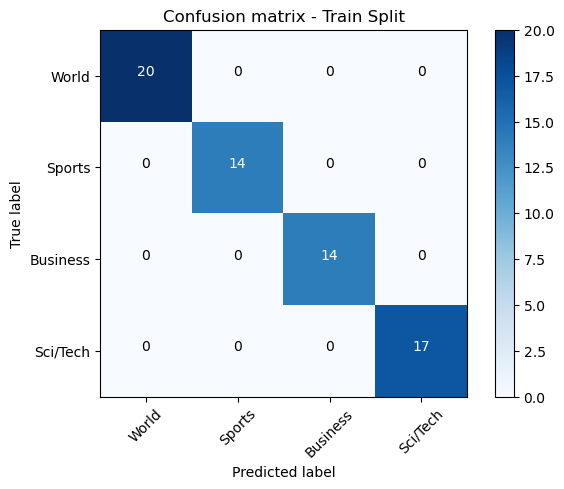

In [45]:
conf = confusion_matrix(counts_train["Label"], predictions_train)

plt.figure()
plot = plot_confusion_matrix(conf, classes = ["World", "Sports", "Business", "Sci/Tech"], title = "Confusion matrix - Train Split")
plt.show()

In [47]:
print("Train Accuracy: ", accuracy_score(counts_train["Label"], predictions_train))

Train Accuracy:  1.0


### ...and on the test data

In [46]:
tqdm.pandas(desc = "progress bar")
predictions_test = counts_test.progress_apply(lambda row: NB.predict(row, has_target = True), axis = 1)

progress bar:   0%|                                                    | 0/35 [00:00<?, ?it/s]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   6%|██▌                                         | 2/35 [00:01<00:31,  1.04it/s]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:   9%|███▊                                        | 3/35 [00:03<00:43,  1.36s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  11%|█████                                       | 4/35 [00:05<00:48,  1.56s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  14%|██████▎                                     | 5/35 [00:07<00:50,  1.68s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  17%|███████▌                                    | 6/35 [00:09<00:51,  1.77s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  20%|████████▊                                   | 7/35 [00:11<00:51,  1.83s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  23%|██████████                                  | 8/35 [00:13<00:50,  1.86s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  26%|███████████▎                                | 9/35 [00:15<00:48,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  29%|████████████▎                              | 10/35 [00:17<00:47,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  31%|█████████████▌                             | 11/35 [00:19<00:45,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  34%|██████████████▋                            | 12/35 [00:21<00:43,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  37%|███████████████▉                           | 13/35 [00:22<00:41,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  40%|█████████████████▏                         | 14/35 [00:24<00:39,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  43%|██████████████████▍                        | 15/35 [00:26<00:37,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  46%|███████████████████▋                       | 16/35 [00:28<00:35,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  49%|████████████████████▉                      | 17/35 [00:30<00:33,  1.88s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  51%|██████████████████████                     | 18/35 [00:32<00:32,  1.89s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  54%|███████████████████████▎                   | 19/35 [00:34<00:30,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  57%|████████████████████████▌                  | 20/35 [00:36<00:28,  1.92s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  60%|█████████████████████████▊                 | 21/35 [00:38<00:27,  1.93s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  63%|███████████████████████████                | 22/35 [00:40<00:24,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  66%|████████████████████████████▎              | 23/35 [00:42<00:23,  1.94s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  69%|█████████████████████████████▍             | 24/35 [00:44<00:21,  1.94s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  71%|██████████████████████████████▋            | 25/35 [00:45<00:19,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  74%|███████████████████████████████▉           | 26/35 [00:47<00:17,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  77%|█████████████████████████████████▏         | 27/35 [00:49<00:15,  1.95s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  80%|██████████████████████████████████▍        | 28/35 [00:51<00:13,  1.93s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  83%|███████████████████████████████████▋       | 29/35 [00:53<00:11,  1.95s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  86%|████████████████████████████████████▊      | 30/35 [00:55<00:09,  1.92s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  89%|██████████████████████████████████████     | 31/35 [00:57<00:07,  1.90s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  91%|███████████████████████████████████████▎   | 32/35 [00:59<00:05,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  94%|████████████████████████████████████████▌  | 33/35 [01:01<00:03,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar:  97%|█████████████████████████████████████████▊ | 34/35 [01:03<00:01,  1.91s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar: 100%|███████████████████████████████████████████| 35/35 [01:05<00:00,  1.92s/it]

    000  08  10  100  11  12th  15  16  18  1904  ...  www  yasir  yasser  \
0     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
1     0   0   0    0   1     0   0   0   0     0  ...    0      0       0   
2     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
3     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
4     0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
..  ...  ..  ..  ...  ..   ...  ..  ..  ..   ...  ...  ...    ...     ...   
60    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
61    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
62    0   0   0    0   0     0   0   0   1     0  ...    0      0       0   
63    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   
64    0   0   0    0   0     0   0   0   0     0  ...    0      0       0   

    year  years  yes  yielding  york  zurich     Label  
0      0      0   

progress bar: 100%|███████████████████████████████████████████| 35/35 [01:07<00:00,  1.92s/it]


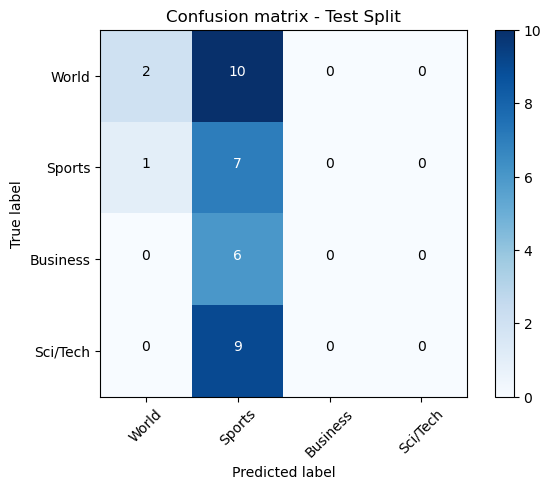

In [48]:
conf = confusion_matrix(counts_test["Label"], predictions_test)

plt.figure()
plot = plot_confusion_matrix(conf, classes = ["World", "Sports", "Business", "Sci/Tech"], title = "Confusion matrix - Test Split")
plt.show()

In [49]:
print("Test Accuracy: ", accuracy_score(counts_test["Label"], predictions_test))

Test Accuracy:  0.2571428571428571


### What can you observe?

Does it work well? What does accuracy in this context mean given that we have four balanced classes (and we assume that our sample is truly random)? What could be pitfalls why the classifier doesn't work well?

### **Bonus Exercise:** Performance on "cleaned" data.

Run the naiveBayes classifier on the "cleaned" dataset from the clustering exercise. For example, import the cleaning function from `clean.py` and apply it to training and test partition with the code below:

```python
from clean import clean

docs_cleaned_train = [clean(row["Article"]) for i, row in train.iterrows()]
docs_cleaned_test = [clean(row["Article"]) for i, row in test.iterrows()]
```

Compare the performance between the "cleaned" and "not cleaned" datasets, which one performs better?

### **Bonus Exercise:** Speeding up naiveBayes.

As you can see this implementation of the naiveBayes classification algorithm is very slow and inefficient. How could we potentially improve performance and speed up prediction? Try to implement a more efficient naiveBayes classifier.

### **Alternative/Bonus Exercise:** Implement the kNN algorithm using the TF-IDF matrix representation and using the cosine distance!

Compare (the performance of) your solution to that of the kNN implementation of sklearn: [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)